In [44]:
import os
from keras.preprocessing.image import  ImageDataGenerator
from keras.layers import Dense,Flatten,GlobalAveragePooling2D,Input,Conv2D,MaxPooling2D,Dropout
from keras.models import Model,load_model,Sequential
from keras.applications.xception import  Xception
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import  ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.mobilenet import MobileNet
import keras.callbacks as kcallbacks
import keras

from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
#from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import image_utils


import math
import random
from keras.utils import plot_model
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import numpy as np
from PIL import Image
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

In [45]:
#generate training and test images
TARGET_SIZE=(224,224)
INPUT_SIZE=(224,224,3)        #输入大小设为（224,224,3）
BATCHSIZE=128	#could try 128 or 32  #批量大小设置为128

#Normalization
#ImageDataGenerator，rescale的作用是对图片的每个像素值均乘上这个放缩因子，这个操作在所有其它变换操作之前执行，在一些模型当中，
#直接输入原图的像素值可能会落入激活函数的“死亡区”，因此设置放缩因子为1/255，把像素值放缩到0和1之间有利于模型的收敛，避免神经元“死亡”。
train_datagen = ImageDataGenerator(rescale=1./255)  ##归一化

test_datagen = ImageDataGenerator(rescale=1./255)   # #不增强验证数据

train_generator = train_datagen.flow_from_directory(  #从指定的目录中生成训练图像
        './dataset/train_224',##训练文件路径--文件夹下多分类文件夹
        target_size=TARGET_SIZE,                     #目标大小设置为(224,224)，图像统一尺寸
        batch_size=BATCHSIZE,                        #batch数据的大小,默认32
        class_mode='categorical')                   #返回标签数组形式 'binary'二进制；
validation_generator = test_datagen.flow_from_directory(  #从指定的目录中生成测试图像
        './dataset/test_224',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')

Found 4313 images belonging to 5 classes.
Found 1024 images belonging to 5 classes.


In [46]:
#plot the figures
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch': [], 'epoch': []}
        self.accuracy = {'batch': [], 'epoch': []}
        self.val_loss = {'batch': [], 'epoch': []}
        self.val_acc = {'batch': [], 'epoch': []}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('accuracy'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_accuracy'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('accuracy'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_accuracy'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        #创建一个图
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')#plt.plot(x,y)，这个将数据画成曲线
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)#设置网格形式
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')#给x，y轴加注释
        plt.legend(loc="upper right")#设置图例显示位置
        plt.savefig('acc-loss.jpg', dpi=800)
        plt.show()

In [47]:
#创建一个LossHistory的实例
history_this= LossHistory()

/tmp/ipykernel_19508/1768708959.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/20
34/34 [==============================] - 10s 248ms/step - loss: 1.3706 - accuracy: 0.4915
Epoch 2/20
34/34 [==============================] - 9s 246ms/step - loss: 0.6757 - accuracy: 0.9511
Epoch 3/20
34/34 [==============================] - 9s 247ms/step - loss: 0.2303 - accuracy: 0.9835
Epoch 4/20
34/34 [==============================] - 9s 246ms/step - loss: 0.0770 - accuracy: 0.9914
Epoch 5/20
34/34 [==============================] - 9s 247ms/step - loss: 0.0375 - accuracy: 0.9937
Epoch 6/20
34/34 [==============================] - 9s 250ms/step - loss: 0.0227 - accuracy: 0.9963
Epoch 7/20
34/34 [==============================] - 9s 249ms/step - loss: 0.0140 - accuracy: 0.9981
Epoch 8/20
34/34 [==============================] - 9s 248ms/step - loss: 0.0095 - accuracy: 0.9988
Epoch 9/20
34/34 [==============================] - 9s 249ms/step - loss: 0.0064 - accuracy: 0.9995
Epoch 10/20
34/34 [==============================] - 9s 247ms/step - loss: 0.0043 - accuracy: 1.000

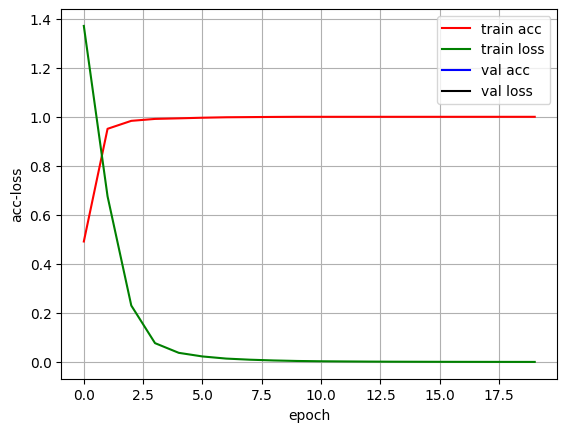

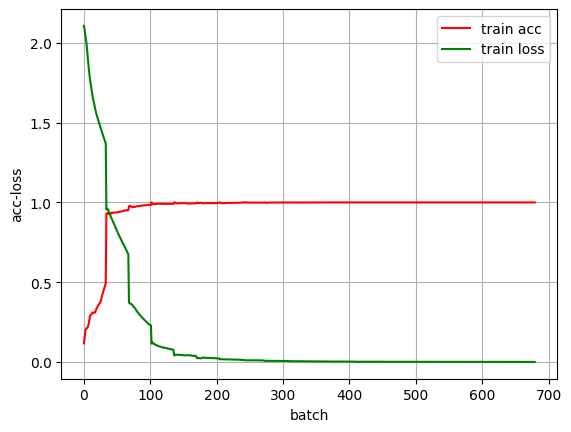

In [48]:
def vgg16(num_class, epochs, savepath='./VGG16.h5', history=history_this, input_shape=INPUT_SIZE):
    model_fine_tune = VGG16(include_top=True, weights='imagenet', input_shape=input_shape)
    model_output = Dense(num_class, activation='softmax')(model_fine_tune.layers[-2].output)  # Output layer with num_class units and softmax activation
    model = Model(model_fine_tune.input, model_output, name='vgg')

    opt = keras.optimizers.Adam(lr=0.000001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        verbose=1,
        save_best_only=True,
        mode='auto')

    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        callbacks=[saveBestModel, history],
    )
    model.save('VGG16_yuan.h5')
    model = load_model('VGG16_yuan.h5')

# Call the function with appropriate arguments
vgg16(num_class=5, epochs=20)

# Assuming you have the function history_plot implemented somewhere, you can now call it
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()


In [49]:
#load model 1: VGG16
vgg16_yuan_model=load_model('./VGG16_yuan.h5')

In [50]:
#generate labels indicating disease (1) or normal (0)
label=validation_generator.class_indices
label={v: k for k, v in label.items()}

In [51]:
#read images from validation folder
rootdir = './dataset/test_224/'
test_laels = []
test_images=[]
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if not (file.endswith(".jpeg"))|(file.endswith(".jpg"))|(file.endswith(".png")):
            continue
        test_laels.append(subdir.split('/')[-1])
        test_images.append(os.path.join(subdir, file))
        
print(test_laels[0],test_images[0])

4 ./dataset/test_224/4/24381.png


In [52]:
%%time
import time
predict=[]
length=len(test_images)
t1 = time.time()
for i in range(length):
    inputimg=test_images[i]
    test_batch=[]
    thisimg=np.array(Image.open(inputimg))/255 #read all the images in validation set
    #print(thisimg)
    test_shape=(1,)+thisimg.shape
    thisimg=thisimg.reshape(test_shape)
    vgg16_yuan_model_batch=vgg16_yuan_model.predict(thisimg) #use master model to process the input image
    #generate result by model 1
    prob=vgg16_yuan_model_batch[0,np.argmax(vgg16_yuan_model_batch,axis=1)[0]]
    res=label[np.argmax(vgg16_yuan_model_batch,axis=1)[0]]
    predict.append(res)

# Disable progress bar
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

1/1 [==============================] - 0s 17ms/step
CPU times: user 54.1 s, sys: 3.13 s, total: 57.2 s
Wall time: 53.7 s


In [53]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
acc=accuracy_score(test_laels,predict)
pre=precision_score(test_laels,predict,average='weighted')
re=recall_score(test_laels,predict,average='weighted')
f1=f1_score(test_laels,predict,average='weighted')
print('Xception accuracy: %s'%acc)
print('precision: %s'%pre)
print('recall: %s'%re)
print('f1: %s'%f1)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_laels, predict))
target_names = ['0', '1','2','3','4']
print(classification_report(test_laels, predict, target_names=target_names))

Xception accuracy: 1.0
precision: 1.0
recall: 1.0
f1: 1.0
[[321   0   0   0   0]
 [  0 101   0   0   0]
 [  0   0 200   0   0]
 [  0   0   0 181   0]
 [  0   0   0   0 221]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       321
           1       1.00      1.00      1.00       101
           2       1.00      1.00      1.00       200
           3       1.00      1.00      1.00       181
           4       1.00      1.00      1.00       221

    accuracy                           1.00      1024
   macro avg       1.00      1.00      1.00      1024
weighted avg       1.00      1.00      1.00      1024



/environment/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/tmp/ipykernel_19508/109321406.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/25
34/34 [==============================] - 13s 245ms/step - loss: 1.2489 - accuracy: 0.5282
Epoch 2/25
34/34 [==============================] - 9s 246ms/step - loss: 0.6499 - accuracy: 0.7851
Epoch 3/25
34/34 [==============================] - 9s 245ms/step - loss: 0.3886 - accuracy: 0.9019
Epoch 4/25
34/34 [==============================] - 8s 242ms/step - loss: 0.2606 - accuracy: 0.9518
Epoch 5/25
34/34 [==============================] - 9s 245ms/step - loss: 0.1864 - accuracy: 0.9719
Epoch 6/25
34/34 [==============================] - 9s 244ms/step - loss: 0.1439 - accuracy: 0.9782
Epoch 7/25
34/34 [==============================] - 9s 246ms/step - loss: 0.1179 - accuracy: 0.9810
Epoch 8/25
34/34 [==============================] - 9s 247ms/step - loss: 0.0941 - accuracy: 0.9866
Epoch 9/25
34/34 [==============================] - 9s 248ms/step - loss: 0.0762 - accuracy: 0.9893
Epoch 10/25
34/34 [==============================] - 9s 243ms/step - loss: 0.0627 - accuracy: 0.993

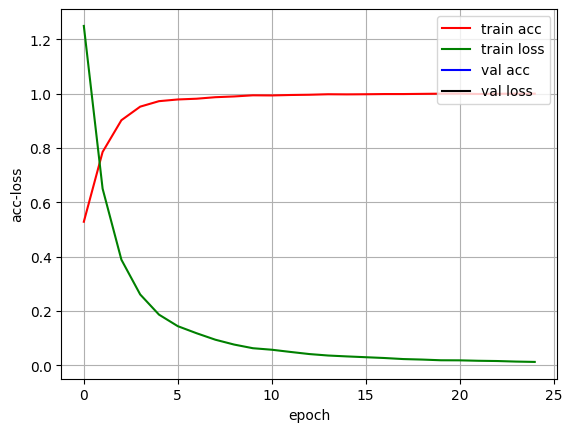

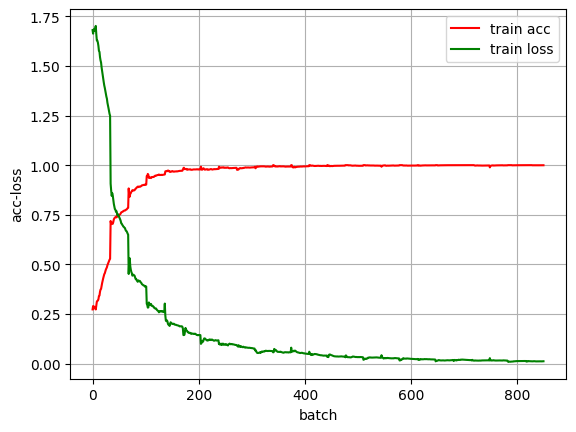

In [54]:
from keras.applications import ResNet50

def resnet50(num_class, epochs, savepath='./resnet.h5', history=history_this, input_shape=INPUT_SIZE):
    model_fine_tune = ResNet50(include_top=True, weights='imagenet', input_shape=input_shape)
    model_output = Dense(num_class, activation='softmax')(model_fine_tune.layers[-2].output)  # Output layer with num_class units and softmax activation
    model = Model(model_fine_tune.input, model_output, name='resnet')

    opt = keras.optimizers.Adam(lr=0.000001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        verbose=1,
        save_best_only=True,
        mode='auto')

    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        callbacks=[saveBestModel, history],
    )
    model.save('resnet50_yuan.h5')
    model = load_model('resnet50_yuan.h5')

# Call the function with appropriate arguments
resnet50(num_class=5, epochs=25)

# Assuming you have the function history_plot implemented somewhere, you can now call it
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()


In [55]:
#load model 1: VGG16
resnet50_yuan_model=load_model('./resnet50_yuan.h5')

In [56]:
%%time
import time
predict=[]
length=len(test_images)
t1 = time.time()
for i in range(length):
    inputimg=test_images[i]
    test_batch=[]
    thisimg=np.array(Image.open(inputimg))/255 #read all the images in validation set
    #print(thisimg)
    test_shape=(1,)+thisimg.shape
    thisimg=thisimg.reshape(test_shape)
    resnet50_yuan_model_batch=resnet50_yuan_model.predict(thisimg) #use master model to process the input image
    #generate result by model 1
    prob=resnet50_yuan_model_batch[0,np.argmax(resnet50_yuan_model_batch,axis=1)[0]]
    res=label[np.argmax(resnet50_yuan_model_batch,axis=1)[0]]
    predict.append(res)

# Disable progress bar
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
    

1/1 [==============================] - 0s 20ms/step
CPU times: user 1min 3s, sys: 3.5 s, total: 1min 6s
Wall time: 1min 1s


In [57]:
%%time
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
acc=accuracy_score(test_laels,predict)
pre=precision_score(test_laels,predict,average='weighted')
re=recall_score(test_laels,predict,average='weighted')
f1=f1_score(test_laels,predict,average='weighted')
print('resnet accuracy: %s'%acc)
print('precision: %s'%pre)
print('recall: %s'%re)
print('f1: %s'%f1)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_laels, predict))
target_names = ['0', '1','2','3','4']
print(classification_report(test_laels, predict, target_names=target_names))

resnet accuracy: 0.4521484375
precision: 0.33717782224258114
recall: 0.4521484375
f1: 0.36167116648716036
[[195  87  39   0   0]
 [ 20  80   1   0   0]
 [  0  13 187   0   0]
 [ 60   0  85   0  36]
 [  5   1 214   0   1]]
              precision    recall  f1-score   support

           0       0.70      0.61      0.65       321
           1       0.44      0.79      0.57       101
           2       0.36      0.94      0.52       200
           3       0.00      0.00      0.00       181
           4       0.03      0.00      0.01       221

    accuracy                           0.45      1024
   macro avg       0.30      0.47      0.35      1024
weighted avg       0.34      0.45      0.36      1024

CPU times: user 23.1 ms, sys: 3.28 ms, total: 26.4 ms
Wall time: 25.8 ms


/environment/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/environment/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/environment/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/environment/miniconda3/lib/python3.8/sit

/environment/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/tmp/ipykernel_19508/2904517614.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/25
34/34 [==============================] - 13s 242ms/step - loss: 1.1968 - accuracy: 0.5933
Epoch 2/25
34/34 [==============================] - 9s 245ms/step - loss: 0.5823 - accuracy: 0.8711
Epoch 3/25
34/34 [==============================] - 9s 245ms/step - loss: 0.3642 - accuracy: 0.9177
Epoch 4/25
34/34 [==============================] - 9s 245ms/step - loss: 0.2482 - accuracy: 0.9469
Epoch 5/25
34/34 [==============================] - 9s 246ms/step - loss: 0.1842 - accuracy: 0.9719
Epoch 6/25
34/34 [==============================] - 9s 244ms/step - loss: 0.1388 - accuracy: 0.9798
Epoch 7/25
34/34 [==============================] - 9s 247ms/step - loss: 0.1097 - accuracy: 0.9861
Epoch 8/25
34/34 [==============================] - 9s 247ms/step - loss: 0.0889 - accuracy: 0.9877
Epoch 9/25
34/34 [==============================] - 8s 242ms/step - loss: 0.0728 - accuracy: 0.9898
Epoch 10/25
34/34 [==============================] - 9s 248ms/step - loss: 0.0627 - accuracy: 0.992

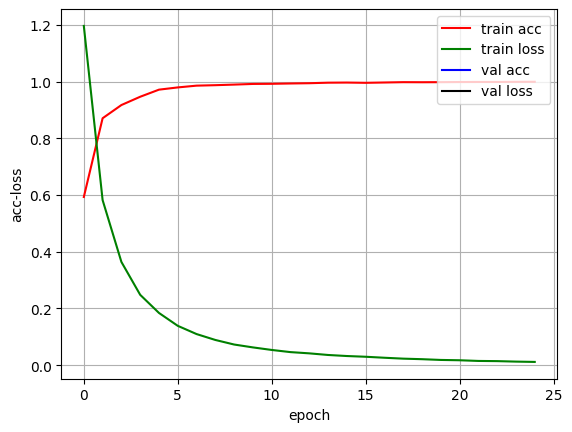

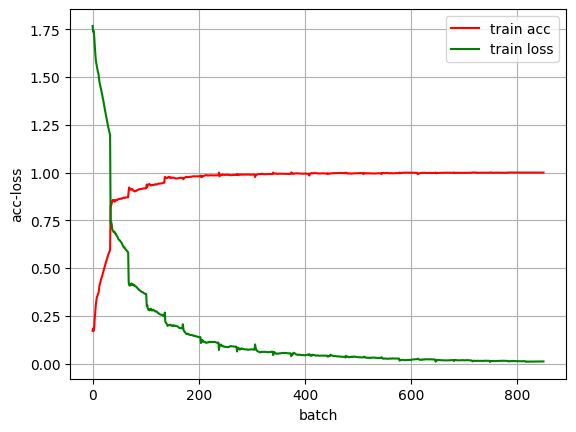

In [58]:
from keras.applications import ResNet50

def inception(num_class, epochs, savepath='./inception.h5', history=history_this, input_shape=INPUT_SIZE):
    model_fine_tune = ResNet50(include_top=True, weights='imagenet', input_shape=input_shape)
    model_output = Dense(num_class, activation='softmax')(model_fine_tune.layers[-2].output)  # Output layer with num_class units and softmax activation
    model = Model(model_fine_tune.input, model_output, name='resnet')

    opt = keras.optimizers.Adam(lr=0.000001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        verbose=1,
        save_best_only=True,
        mode='auto')

    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        callbacks=[saveBestModel, history],
    )
    model.save('inception_yuan.h5')
    model = load_model('inception_yuan.h5')

# Call the function with appropriate arguments
inception(num_class=5, epochs=25)

# Assuming you have the function history_plot implemented somewhere, you can now call it
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()



In [59]:
#load model 1: VGG16
inception_yuan_model=load_model('./inception_yuan.h5')

In [60]:
%%time
import time
predict=[]
length=len(test_images)
t1 = time.time()
for i in range(length):
    inputimg=test_images[i]
    test_batch=[]
    thisimg=np.array(Image.open(inputimg))/255 #read all the images in validation set
    #print(thisimg)
    test_shape=(1,)+thisimg.shape
    thisimg=thisimg.reshape(test_shape)
    inception_yuan_model_batch=inception_yuan_model.predict(thisimg) #use master model to process the input image
    #generate result by model 1
    prob=inception_yuan_model_batch[0,np.argmax(inception_yuan_model_batch,axis=1)[0]]
    res=label[np.argmax(inception_yuan_model_batch,axis=1)[0]]
    predict.append(res)

# Disable progress bar
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
    

1/1 [==============================] - 0s 23ms/step
CPU times: user 1min 3s, sys: 3.42 s, total: 1min 6s
Wall time: 1min 1s


In [61]:
%%time
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
acc=accuracy_score(test_laels,predict)
pre=precision_score(test_laels,predict,average='weighted')
re=recall_score(test_laels,predict,average='weighted')
f1=f1_score(test_laels,predict,average='weighted')
print('resnet accuracy: %s'%acc)
print('precision: %s'%pre)
print('recall: %s'%re)
print('f1: %s'%f1)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_laels, predict))
target_names = ['0', '1','2','3','4']
print(classification_report(test_laels, predict, target_names=target_names))

resnet accuracy: 0.5576171875
precision: 0.36692223411233216
recall: 0.5576171875
f1: 0.4354260675170773
[[309   3   5   4   0]
 [ 21  80   0   0   0]
 [  3  15 182   0   0]
 [  0   2 179   0   0]
 [102  15 104   0   0]]
              precision    recall  f1-score   support

           0       0.71      0.96      0.82       321
           1       0.70      0.79      0.74       101
           2       0.39      0.91      0.54       200
           3       0.00      0.00      0.00       181
           4       0.00      0.00      0.00       221

    accuracy                           0.56      1024
   macro avg       0.36      0.53      0.42      1024
weighted avg       0.37      0.56      0.44      1024

CPU times: user 21.8 ms, sys: 3.65 ms, total: 25.5 ms
Wall time: 24.6 ms


/environment/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/environment/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/environment/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/environment/miniconda3/lib/python3.8/sit

#生成论文需要的图像

In [1]:
import warnings
warnings.filterwarnings("ignore")
import keras
from keras.models import Model,load_model
from keras import Input
from keras.layers import concatenate,Dense,Flatten,Dropout
from keras.preprocessing.image import  ImageDataGenerator
import keras.callbacks as kcallbacks
import os
import math
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from keras.optimizers import SGD
import operator
import numpy as np
from PIL import Image
from collections import defaultdict

In [3]:
#generate images from train set and validation set
TARGET_SIZE=(224,224)
INPUT_SIZE=(224,224,3)
BATCHSIZE=128

test_datagen = ImageDataGenerator(rescale=1./255)


validation_generator = test_datagen.flow_from_directory(
        './dataset/CTU-13andOPCUA/test_224/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')

Found 1024 images belonging to 5 classes.


In [4]:
#generate labels indicating disease (1) or normal (0)
label=validation_generator.class_indices
label={v: k for k, v in label.items()}

In [5]:
#read images from validation folder
rootdir = './dataset/test_224/'
test_laels = []
test_images=[]
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if not (file.endswith(".jpeg"))|(file.endswith(".jpg"))|(file.endswith(".png")):
            continue
        test_laels.append(subdir.split('/')[-1])
        test_images.append(os.path.join(subdir, file))
        
print(test_laels[0],test_images[0])

IndexError: list index out of range

In [66]:
print(label)

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4'}


In [67]:
!pip install opencv-python

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 204.8 MB/s eta 0:00:0000:0100:01


1/1 [==============================] - 0s 19ms/step
True label of the image: 0
Predicted result for the image: 0
Confidence level: 0.9999095


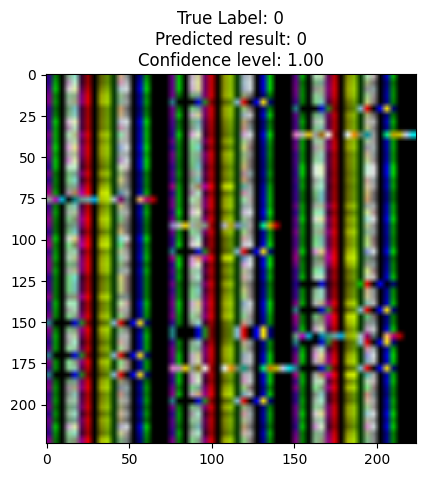

In [72]:
import cv2
import matplotlib.pyplot as plt

test = cv2.imread(test_images[800])
img_show = test[:, :, [2, 1, 0]]
test = test / 255.
test_shape = (1,) + test.shape
test = test.reshape(test_shape)

res = vgg16_model.predict(test)

prob = res[0, np.argmax(res, axis=1)[0]]
res = label[np.argmax(res, axis=1)[0]]
true_label = test_laels[800] 
print('True label of the image: %s' % true_label)
print('Predicted result for the image: %s' % res)
print('Confidence level: %s' % prob)
plt.figure(figsize=(10, 10))
# Save the image with the prediction and confidence level
plt.imshow(img_show)
plt.title('True Label: ' + true_label + '\nPredicted result: ' + res + '\n' + 'Confidence level: {:.2f}'.format(prob))
plt.savefig('predicted_image4.png')  # Save the figure as a PNG image
plt.show()

1/1 [==============================] - 0s 21ms/step
True label of the image: 0
Predicted result for the image: 4
Confidence level: 0.87223434


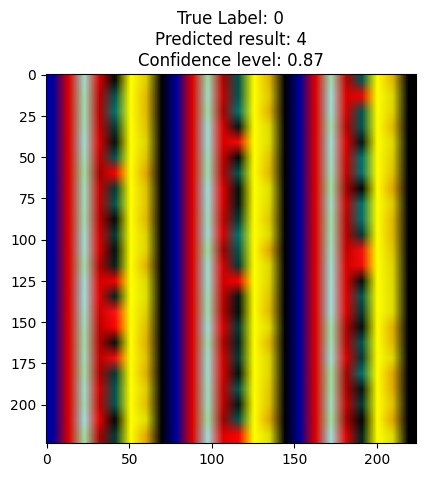

In [73]:
import cv2
import matplotlib.pyplot as plt

test = cv2.imread(test_images[101])
img_show = test[:, :, [2, 1, 0]]
test = test / 255.
test_shape = (1,) + test.shape
test = test.reshape(test_shape)

res = vgg16_model.predict(test)

prob = res[0, np.argmax(res, axis=1)[0]]
res = label[np.argmax(res, axis=1)[0]]
true_label = test_laels[800] 
print('True label of the image: %s' % true_label)
print('Predicted result for the image: %s' % res)
print('Confidence level: %s' % prob)

# Save the image with the prediction and confidence level
plt.imshow(img_show)
plt.title('True Label: ' + true_label + '\nPredicted result: ' + res + '\n' + 'Confidence level: {:.2f}'.format(prob))
plt.savefig('predicted_image4.png')  # Save the figure as a PNG image
plt.show()

1/1 [==============================] - 0s 21ms/step
True label of the image: 0
Predicted result for the image: 2
Confidence level: 0.9989398


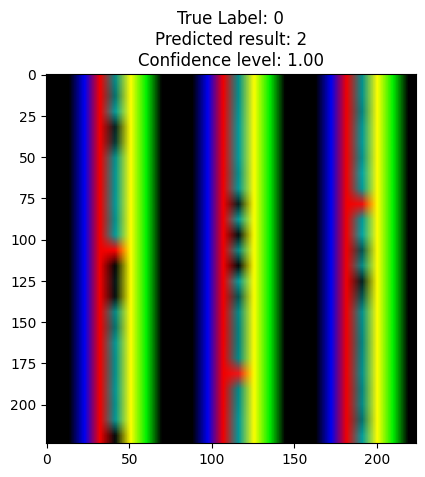

In [74]:
import cv2
import matplotlib.pyplot as plt

test = cv2.imread(test_images[500])
img_show = test[:, :, [2, 1, 0]]
test = test / 255.
test_shape = (1,) + test.shape
test = test.reshape(test_shape)

res = vgg16_model.predict(test)

prob = res[0, np.argmax(res, axis=1)[0]]
res = label[np.argmax(res, axis=1)[0]]
true_label = test_laels[800] 
print('True label of the image: %s' % true_label)
print('Predicted result for the image: %s' % res)
print('Confidence level: %s' % prob)

# Save the image with the prediction and confidence level
plt.imshow(img_show)
plt.title('True Label: ' + true_label + '\nPredicted result: ' + res + '\n' + 'Confidence level: {:.2f}'.format(prob))
plt.savefig('predicted_image4.png')  # Save the figure as a PNG image
plt.show()

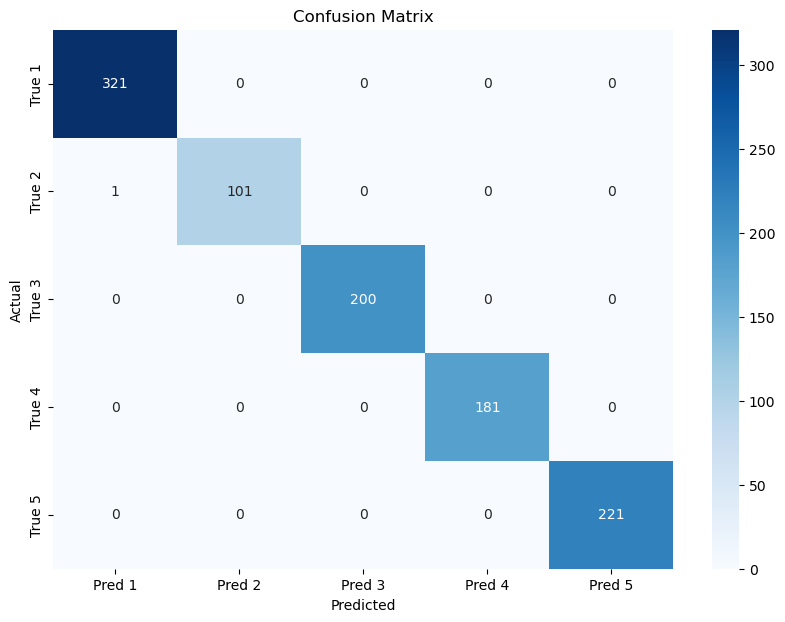

(0.9990243902439024,
          Precision    Recall  F1 Score
 Class 1   0.996894  1.000000  0.998445
 Class 2   1.000000  0.990196  0.995074
 Class 3   1.000000  1.000000  1.000000
 Class 4   1.000000  1.000000  1.000000
 Class 5   1.000000  1.000000  1.000000
 Average   0.999379  0.998039  0.998704)

In [1]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# confusion matrix
cm = np.array([[320, 1, 0, 0, 0],
               [0, 101, 0, 0, 0],
               [0, 0, 200, 0, 0],
               [0, 0, 0, 181, 0],
               [0, 0, 0, 0, 221]])

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Pred 1','Pred 2','Pred 3','Pred 4','Pred 5'], yticklabels=['True 1','True 2','True 3','True 4','True 5'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate metrics
true_positive = np.diag(cm)
false_positive = np.sum(cm, axis=0) - true_positive
false_negative = np.sum(cm, axis=1) - true_positive

precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
accuracy = np.sum(true_positive) / np.sum(cm)
f1_score = 2*precision*recall / (precision + recall)

metrics_df = pd.DataFrame({'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, index=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'])
metrics_df.loc['Average'] = metrics_df.mean()

accuracy, metrics_df
